# 언러닝 라운드와 남은 라운드를 같이 진행


In [1]:
import os
import time
import copy
import json
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
import random

import matplotlib.pyplot as plt     
import torchvision.utils as vutils 

from torch.utils.data import DataLoader, ConcatDataset, Subset #unseen data를 통해서 언러닝 재학습에서 사용.
from torch.utils.data import TensorDataset

from options import args_parser
from update import LocalUpdate, test_inference
from models import CNNMnist,ResNet18, CNNCifar, Generator, Discriminator, generate_images, filter_images
from utils import get_dataset, average_weights, exp_details, create_poisoned_dataset, generate_fixed_threshold_data
from unlearn import (
    train_generator_ungan,
    train_gd_ungan,
    train_gd_ungan_with_unseen,
    train_gd_ungan_unseen_only, 
    train_gd_ungan_forget_only,
    SyntheticImageDataset, 
    partition_synthetic_data_iid,
    partition_synthetic_data_dirichlet,
    get_synthetic_subset
)
from evaluate_mia import evaluate_mia, comprehensive_evaluation, evaluate_synthetic_classification_accuracy, evaluate_classification_accuracy, evaluate_model_comparison


In [2]:
def visualize_real_vs_generated_with_filtering(generator, discriminator, dataset, forget_idxs, 
                                             z_dim=100, device='cpu', threshold=0.5, num_samples=16):
    
    """
    실제 이미지, 생성된 이미지, 필터링된 이미지를 모두 비교 시각화
    """

    # 실제 이미지 샘플링
    real_images = []
    sample_idxs = np.random.choice(forget_idxs, min(num_samples, len(forget_idxs)), replace=False)
    
    for idx in sample_idxs:
        img, _ = dataset[idx]
        real_images.append(img)
    
    real_images = torch.stack(real_images)
    
    # 더 많은 이미지를 생성해서 필터링 효과를 보여주기
    num_generate = num_samples * 2  # 2배 생성해서 필터링
    
    # 생성된 이미지
    generator.eval()
    discriminator.eval()
    with torch.no_grad():
        # 기존: noise = torch.randn(num_generate, z_dim, device=device)
        # 수정: DCGAN 형식으로 (batch, z_dim, 1, 1)
        noise = torch.randn(num_generate, z_dim, 1, 1, device=device)
        
        generated_images = generator(noise)
        
        # Discriminator로 품질 평가
        d_scores = discriminator(generated_images.to(device))
        
        # CPU로 이동하고 정규화
        generated_images = generated_images.cpu()
        generated_images = torch.clamp(generated_images, -1, 1)
        generated_images = (generated_images + 1) / 2
        
        # 필터링 (threshold 이상만 선택)
        d_scores = d_scores.cpu().squeeze()
        high_quality_mask = d_scores > threshold
        
        if high_quality_mask.sum() > 0:
            filtered_images = generated_images[high_quality_mask]
            filtered_scores = d_scores[high_quality_mask]
            # 상위 num_samples개만 선택
            if len(filtered_images) > num_samples:
                top_indices = torch.topk(filtered_scores, num_samples)[1]
                filtered_images = filtered_images[top_indices]
        else:
            # 필터링된 이미지가 없으면 상위 점수 이미지들 선택
            top_indices = torch.topk(d_scores, num_samples)[1]
            filtered_images = generated_images[top_indices]
    
    # 실제 이미지 정규화
    if real_images.min() < 0:  # 이미 정규화된 경우
        real_images = (real_images + 1) / 2
    elif real_images.max() > 1:  # 0-255 범위
        real_images = real_images / 255.0
    
    # 3행으로 비교 시각화
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 9))
    
    # 실제 이미지
    real_grid = vutils.make_grid(real_images, nrow=8, normalize=False, padding=2)
    real_grid_np = real_grid.permute(1, 2, 0).numpy()
    ax1.imshow(real_grid_np, cmap='gray' if real_images.shape[1] == 1 else None)
    ax1.set_title('Real Images (Forget Set)', fontsize=14)
    ax1.axis('off')
    
    # 모든 생성된 이미지 (처음 num_samples개)
    all_gen_grid = vutils.make_grid(generated_images[:num_samples], nrow=8, normalize=False, padding=2)
    all_gen_grid_np = all_gen_grid.permute(1, 2, 0).numpy()
    ax2.imshow(all_gen_grid_np, cmap='gray' if generated_images.shape[1] == 1 else None)
    ax2.set_title('All Generated Images', fontsize=14)
    ax2.axis('off')
    
    # 필터링된 고품질 이미지
    filtered_grid = vutils.make_grid(filtered_images, nrow=8, normalize=False, padding=2)
    filtered_grid_np = filtered_grid.permute(1, 2, 0).numpy()
    ax3.imshow(filtered_grid_np, cmap='gray' if filtered_images.shape[1] == 1 else None)
    ax3.set_title(f'High-Quality Filtered Images (D-score > {threshold})', fontsize=14)
    ax3.axis('off')
    
    plt.tight_layout()
    plt.savefig('./real_vs_generated_filtered.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # Discriminator 점수 통계 출력
    print(f"Discriminator Scores - Mean: {d_scores.mean():.3f}, Std: {d_scores.std():.3f}")
    print("Comparison image saved to: ./real_vs_generated_filtered.png")


def move_dataset_to_device(dataset, device):
    images = []
    labels = []
    for x, y in dataset:
        images.append(x.to(device))
        labels.append(torch.tensor(y).to(device))
    return TensorDataset(torch.stack(images), torch.stack(labels))


def add_backdoor_trigger(x):
    x_bd = x.clone()
    x_bd[:, 25:28, 25:28] = 0.9
    return x_bd

def evaluate_backdoor_asr(model, dataset, target_label, device):
    model.eval()
    total = 0
    correct = 0
    with torch.no_grad():
        for i in range(len(dataset)):
            x, y = dataset[i]
            # 백도어 트리거 삽입
            x_bd = add_backdoor_trigger(x).to(device)
            x_bd = x_bd.unsqueeze(0)  # 배치 차원 추가

            output = model(x_bd)
            pred = output.argmax(dim=1).item()

            total += 1
            if pred == target_label:
                correct += 1

    asr = correct / total
    return asr

def select_model(args, train_dataset):
    if args.model == 'cnn':
        if args.dataset == 'cifar':
            return CNNCifar(args=args)  # CIFAR-10용 CNN 추가 필요
        else:
            return CNNMnist(args=args)  # MNIST용 CNN
    elif args.model == 'resnet':
        return ResNet18(num_classes=args.num_classes)  # CIFAR-10용 ResNet
    else:
        raise NotImplementedError


In [3]:
def main():
    start_time = time.time()
    args = args_parser()
    
    # ===================== 0. 랜덤 시드 설정 (재현성) =====================
    seed = 42
    
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
    print(f"Random seed set to: {seed}")
    
    device = 'cuda' if args.gpu and torch.cuda.is_available() else 'cpu'

    exp_details(args)

    # ===================== 1. 데이터셋 로딩 및 초기화 =====================
    train_dataset, test_dataset, unseen_dataset, user_groups = get_dataset(args)
    full_dataset = train_dataset  

    global_model = select_model(args, full_dataset).to(device)
    global_model.train()

    if args.dataset == 'cifar':
        generator = Generator(z_dim=args.z_dim, img_shape=(3, 32, 32)).to(device)      
        discriminator = Discriminator(img_shape=(3, 32, 32)).to(device)                
    else:
        generator = Generator(z_dim=args.z_dim).to(device)
        discriminator = Discriminator().to(device)

    # DCGAN 가중치 초기화 적용
    from models import weights_init

    generator.apply(weights_init)
    discriminator.apply(weights_init)
    
    global_weights = global_model.state_dict()
    train_loss, train_accuracy = [], []

    forget_client = 0
    forget_idxs = user_groups[forget_client]
    retain_idxs = [i for i in range(len(train_dataset)) if i not in forget_idxs]
    test_idxs = np.random.choice(len(test_dataset), len(forget_idxs), replace=False)

    # Source-Free를 위한 IID Unseen 데이터 준비
    from utils import create_iid_unseen_data
    
    iid_unseen_dataset = create_iid_unseen_data(unseen_dataset, forget_idxs, train_dataset)
    
    # 데이터 분배 정보 출력 
    print("\n" + "-"*70)
    print("DATASET DISTRIBUTION".center(70))
    print("-"*70)
    print(f"Total Training Data: {len(full_dataset):,}")
    print(f"Test Data: {len(test_dataset):,}")
    print(f"Unseen Data Pool: {len(unseen_dataset):,}")
    print(f"\nFederated Learning Setup:")
    print(f"   Forget Set Size: {len(forget_idxs):,}")
    print(f"   Retain Set Size: {len(retain_idxs):,}")
    print(f"   IID Unseen Data for Generation: {len(iid_unseen_dataset):,}")
    print("-"*70)



    # ===================== 2. Original 연합학습 (FedAvg 방식) =====================
    print("\n" + "-"*70)
    print("PHASE 1: Original FEDERATED LEARNING".center(70))
    print("-"*70)

    fedavg_start_time = time.time()
    unlearning_request_epoch = args.epochs // 2
    unlearning_requested = False

    for epoch in tqdm(range(args.epochs), desc='Original FL Training'):
        if epoch == unlearning_request_epoch and not unlearning_requested:
            print(f"\n[UNLEARNING REQUEST] Client {forget_client} requests unlearning at epoch {epoch + 1}")
            unlearning_requested = True
            # 언러닝 요청 시점의 모델 저장
            unlearning_request_model = copy.deepcopy(global_model)
            break  # 언러닝 요청시 기존 FL 중단

        local_weights, local_losses = [], []
        m = max(int(args.frac * args.num_users), 1)
        idxs_users = np.random.choice(range(args.num_users), m, replace=False)

        for idx in idxs_users:
            local_model = LocalUpdate(args=args, dataset=full_dataset, idxs=user_groups[idx])
            w, loss = local_model.update_weights(model=copy.deepcopy(global_model), global_round=epoch)
            local_weights.append(copy.deepcopy(w))
            local_losses.append(loss)

        global_weights = average_weights(local_weights)
        global_model.load_state_dict(global_weights)
        
        loss_avg = sum(local_losses) / len(local_losses)
        if (epoch + 1) % 5 == 0:
            acc, _ = test_inference(args, global_model, test_dataset)
            print(f"[Standard FL] Epoch {epoch+1}/{args.epochs} | Loss: {loss_avg:.4f} | Acc: {acc*100:.2f}%")

    fedavg_time = time.time() - fedavg_start_time
    
    # 언러닝 요청이 없었다면 전체 학습 완료 모델 사용
    if not unlearning_requested:
        unlearning_request_model = copy.deepcopy(global_model)



    # ===================== 3. Source-Free 합성 데이터 생성 =====================
    print("\n" + "-"*70)
    print("PHASE 2: SOURCE-FREE SYNTHETIC DATA GENERATION".center(70))
    print("-"*70)
    
    generation_start_time = time.time()
    
    print("[Source-Free] Server provides IID unseen data to unlearning client...")
    print("[Source-Free] Client generates synthetic data without direct forget data access...")
    
    # Forget 분포 + Unseen 스타일
    generator, discriminator = train_gd_ungan_with_unseen(
        generator=generator,
        discriminator=discriminator,
        dataset=full_dataset,
        retain_idxs=retain_idxs,
        forget_idxs=forget_idxs,
        device=device,
        lambda_adv=1.0,
        z_dim=args.z_dim,
        batch_size=64,
        epochs=200,   ##간 에폭
        unseen_dataset=iid_unseen_dataset,
        mixing_ratio=0.5
    )

    # 합성 데이터 생성
    synthetic_images, synthetic_labels = generate_fixed_threshold_data(
        generator=generator,
        discriminator=discriminator,
        forget_idxs=forget_idxs,
        dataset=full_dataset,
        device=device,
        z_dim=args.z_dim,
        target_count=len(forget_idxs),
        fixed_threshold=args.gen_threshold,
        batch_size=64
    )

    synthetic_dataset = SyntheticImageDataset(synthetic_images, synthetic_labels)
    generation_time = time.time() - generation_start_time
    
    print(f"[Source-Free] Generated {len(synthetic_images):,} synthetic samples in {generation_time:.2f}s")
   

    print("\n" + "-"*70)
    print("SYNTHETIC DATA VISUALIZATION".center(70))
    print("-"*70)
    visualize_real_vs_generated_with_filtering(
        generator, discriminator, full_dataset, forget_idxs, 
        args.z_dim, device, args.gen_threshold
    )



    # ===================== 4. Original 모델 (언러닝 요청 무시) =====================
    print("\n" + "-"*70)
    print("BASELINE : ORIGINAL MODEL (IGNORING UNLEARNING)".center(70))
    print("-"*70)
    
    original_continue_start = time.time()
    original_model = copy.deepcopy(unlearning_request_model)

    other_clients = list(range(args.num_users))
    other_clients.remove(forget_client)
    
    remaining_epochs = args.epochs - unlearning_request_epoch 
    for epoch in tqdm(range(remaining_epochs), desc='Original Continue Training'):
        local_weights, local_losses = [], []
        m = max(int(args.frac * args.num_users), 1)
        idxs_users = np.random.choice(range(args.num_users), m, replace=False)

        for idx in idxs_users:
            local_model = LocalUpdate(args=args, dataset=full_dataset, idxs=user_groups[idx])
            w, loss = local_model.update_weights(model=copy.deepcopy(original_model), global_round=epoch)
            local_weights.append(copy.deepcopy(w))
            local_losses.append(loss)

        global_weights = average_weights(local_weights)
        original_model.load_state_dict(global_weights)

    original_continue_time = time.time() - original_continue_start



    # ===================== 5. Retrain 모델 (이상적인 기준점) =====================
    print("\n" + "-"*70)
    print("BASELINE : RETRAIN MODEL (IDEAL UNLEARNING)".center(70))
    print("-"*70)
    
    retrain_start_time = time.time()
    retrain_model = select_model(args, full_dataset).to(device)
    
    # 언러닝 클라이언트 제외하고 처음부터 재훈련
    for epoch in tqdm(range(args.epochs), desc='Retrain FL Training'):
        local_weights, local_losses = [], []
        m = max(int(args.frac * len(other_clients)), 1)
        idxs_users = np.random.choice(other_clients, m, replace=False)

        for idx in idxs_users:
            local_model = LocalUpdate(args=args, dataset=full_dataset, idxs=user_groups[idx])
            w, loss = local_model.update_weights(model=copy.deepcopy(retrain_model), global_round=epoch)
            local_weights.append(copy.deepcopy(w))
            local_losses.append(loss)

        if local_weights:
            global_weights = average_weights(local_weights)
            retrain_model.load_state_dict(global_weights)

    retrain_time = time.time() - retrain_start_time




    # ===================== 6. Finetune Model ===============================
    print("\n" + "-"*70)
    print("Baseline : SIMPLE Finetune PROCESS".center(70))
    print("-"*70)

    
    finetune_start_time = time.time()
    finetune_model = copy.deepcopy(unlearning_request_model)
    
    remaining_epochs = args.epochs - unlearning_request_epoch 
    for epoch in tqdm(range(remaining_epochs), desc='Finetune FL'):
        local_weights, local_losses = [], []
        
        m = max(int(args.frac * len(other_clients)), 1)
        idxs_users = np.random.choice(other_clients, m, replace=False)

        for idx in idxs_users:
            local_model = LocalUpdate(args=args, dataset=full_dataset, idxs=user_groups[idx])
            w, loss = local_model.update_weights(model=copy.deepcopy(finetune_model), global_round=epoch)
            local_weights.append(copy.deepcopy(w))
            local_losses.append(loss)

        if local_weights:
            global_weights = average_weights(local_weights)
            finetune_model.load_state_dict(global_weights)
            
            loss_avg = sum(local_losses) / len(local_losses)
            if (epoch + 1) % 5 == 0:
                print(f"[Post-Unlearning FL] Epoch {epoch+1}/{remaining_epochs} | Loss: {loss_avg:.4f}")

    finetune_time = time.time() - finetune_start_time

  

    # ===================== 7. Unlearn Model (합성 데이터 기반 언러닝) =====================
    print("\n" + "-"*70)
    print("BaseLine : UNLEARN MODEL WITH SYNTHETIC DATA".center(70))
    print("-"*70)

    unlearn_start_time = time.time()
    unlearn_model = copy.deepcopy(unlearning_request_model)
    
    remaining_epochs = args.epochs - unlearning_request_epoch 
    for epoch in tqdm(range(remaining_epochs), desc='Unlearning FL'):
        local_weights, local_losses = [], []
        
        m = max(int(args.frac * args.num_users), 1)
        idxs_users = np.random.choice(range(args.num_users), m, replace=False)

        for idx in idxs_users:
            if idx == forget_client:  # 수정: forget_client와 비교
                local_model = LocalUpdate(args=args, dataset=synthetic_dataset)
                w, loss = local_model.synthetic_update_weights(
                    model=copy.deepcopy(unlearn_model), 
                    global_round=epoch,
                    synthetic_dataset=synthetic_dataset
                )
            else:
                local_model = LocalUpdate(args=args, dataset=full_dataset, idxs=user_groups[idx])
                w, loss = local_model.update_weights(model=copy.deepcopy(unlearn_model), global_round=epoch)

            local_weights.append(copy.deepcopy(w))
            local_losses.append(loss)

        if local_weights:
            global_weights = average_weights(local_weights)
            unlearn_model.load_state_dict(global_weights)
            
            loss_avg = sum(local_losses) / len(local_losses)
            if (epoch + 1) % 5 == 0:
                print(f"[Unlearning FL] Epoch {epoch+1}/{remaining_epochs} | Loss: {loss_avg:.4f}")

    unlearn_time = time.time() - unlearn_start_time



    # # ===================== 7. Unlearn Model (합성 데이터 기반 언러닝) =====================
    # print("\n" + "-"*70)
    # print("BaseLine : UNLEARN MODEL WITH SYNTHETIC DATA".center(70))
    # print("-"*70)

    # unlearn_start_time = time.time()
    # unlearn_model = copy.deepcopy(unlearning_request_model)

    # # 언러닝 전용 라운드 수 (먼저 수행)
    # extra_unlearning_rounds = 30  # 필요에 맞게 조정

    # remaining_epochs = args.epochs - unlearning_request_epoch

    # # -------- Phase A: 언러닝 전용 라운드 (forget_client만 참여) --------
    # for epoch in tqdm(range(extra_unlearning_rounds), desc='Unlearning FL (extra-only)'):
    #     local_weights, local_losses = [], []

    #     # 언러닝 클라이언트만 단독 참여
    #     idxs_users = {forget_client}

    #     for idx in idxs_users:
    #         local_model = LocalUpdate(args=args, dataset=synthetic_dataset)
    #         w, loss = local_model.synthetic_update_weights(
    #             model=copy.deepcopy(unlearn_model),
    #             global_round=epoch,
    #             synthetic_dataset=synthetic_dataset
    #         )
    #         local_weights.append(copy.deepcopy(w))
    #         local_losses.append(loss)

    #     if local_weights:
    #         global_weights = average_weights(local_weights)
    #         unlearn_model.load_state_dict(global_weights)

    #         if (epoch + 1) % 5 == 0:
    #             loss_avg = sum(local_losses) / len(local_losses)
    #             # === 기존 포맷 유지 ===
    #             print(f"[Unlearning FL] Epoch {epoch+1}/{extra_unlearning_rounds} | Loss: {loss_avg:.4f}")

    # # -------- Phase B: remain 라운드 (기존 FL 진행) --------
    # for epoch in tqdm(range(remaining_epochs), desc='Unlearning FL (remain)'):
    #     local_weights, local_losses = [], []

    #     m = max(int(args.frac * args.num_users), 1)
    #     idxs_users = set(np.random.choice(range(args.num_users), m, replace=False))

    #     # 필요 시 언러닝 클라 계속 포함하고 싶으면 아래 주석 해제
    #     # idxs_users.add(forget_client)

    #     for idx in idxs_users:
    #         if idx == forget_client:
    #             local_model = LocalUpdate(args=args, dataset=synthetic_dataset)
    #             w, loss = local_model.synthetic_update_weights(
    #                 model=copy.deepcopy(unlearn_model),
    #                 global_round=epoch,
    #                 synthetic_dataset=synthetic_dataset
    #             )
    #         else:
    #             local_model = LocalUpdate(args=args, dataset=full_dataset, idxs=user_groups[idx])
    #             w, loss = local_model.update_weights(model=copy.deepcopy(unlearn_model), global_round=epoch)

    #         local_weights.append(copy.deepcopy(w))
    #         local_losses.append(loss)

    #     if local_weights:
    #         global_weights = average_weights(local_weights)
    #         unlearn_model.load_state_dict(global_weights)

    #         if (epoch + 1) % 5 == 0:
    #             loss_avg = sum(local_losses) / len(local_losses)
    #             # === 기존 포맷 유지 ===
    #             print(f"[Unlearning FL] Epoch {epoch+1}/{remaining_epochs} | Loss: {loss_avg:.4f}")

    # unlearn_time = time.time() - unlearn_start_time



    # ===================== 8. 종합 평가 =====================
    print("\n" + "-"*70)
    print("COMPREHENSIVE EVALUATION".center(70))
    print("-"*70)

    
    evaluation_results = evaluate_model_comparison(
        original_model=original_model,
        retrain_model=retrain_model,
        finetune_model=finetune_model,
        unlearn_model=unlearn_model, 
        train_dataset=full_dataset,
        test_dataset=test_dataset,
        forget_idxs=forget_idxs,
        retain_idxs=retain_idxs,
        synthetic_dataset=synthetic_dataset,
        device=device,
        save_path='./results/comprehensive_evaluation.json'
    )



    # # ===================== 9. IID vs Non-IID 비교 (필요시) =====================
    # if not args.iid:
    #     print("\n" + "-"*70)
    #     print("IID vs NON-IID COMPARISON".center(70))
    #     print("-"*70)
        
    #     # IID 설정으로 한 번 더 실험
    #     args_iid = copy.deepcopy(args)
    #     args_iid.iid = 1
        
    #     train_iid, test_iid, _, groups_iid = get_dataset(args_iid)
        
    #     datasets_dict = {
    #         'noniid': {
    #             'train_dataset': full_dataset,
    #             'test_dataset': test_dataset,
    #             'forget_idxs': forget_idxs,
    #             'retain_idxs': retain_idxs
    #         },
    #         'iid': {
    #             'train_dataset': train_iid,
    #             'test_dataset': test_iid,
    #             'forget_idxs': groups_iid[forget_client],
    #             'retain_idxs': [idx for i, group in groups_iid.items() 
    #                            if i != forget_client for idx in group]
    #         }
    #     }
        
    #     models_dict = {
    #         'Original': original_model,
    #         'Retrain': retrain_model,
    #         'Finetune': finetune_model,
    #         'Unlearn':unlearn_model
    #     }
        
    #     from evaluate_mia import evaluate_iid_vs_noniid
    #     iid_comparison = evaluate_iid_vs_noniid(
    #         models_dict=models_dict,
    #         datasets_dict=datasets_dict,
    #         device=device,
    #         save_path='./results/iid_vs_noniid_comparison.json'
    #     )


    # ===================== 10. MIA 평가 (기존 형식 유지) =====================
    print("\n" + "-"*70)
    print("MEMBERSHIP INFERENCE ATTACK EVALUATION".center(70))
    print("-"*70)

    all_idxs = set(range(len(full_dataset)))
    non_member_candidates = list(all_idxs - set(forget_idxs))
    
    print(f"\n[MIA] Original Model:")
    mia_result_original = evaluate_mia(
        model=original_model,
        dataset=full_dataset,
        test_dataset=test_dataset,
        forget_idxs=forget_idxs,
        retain_idxs=test_idxs,
        shadow_idxs=np.random.choice(non_member_candidates, len(forget_idxs), replace=False),
        device=device,
        save_path="./mia_result_original.json"
    )
    
    print(f"\n[MIA] Retrain Model:")
    mia_retrain_after = evaluate_mia(
        model=retrain_model,
        dataset=full_dataset,
        test_dataset=test_dataset,
        forget_idxs=forget_idxs,
        retain_idxs=test_idxs,
        shadow_idxs=np.random.choice(non_member_candidates, len(forget_idxs), replace=False),
        device=device,
        save_path="./mia_result_retrain.json"
    )
    
    print(f"\n[MIA] Finetune Model:")
    mia_finetune_after = evaluate_mia(
        model=finetune_model,
        dataset=full_dataset,
        test_dataset=test_dataset,
        forget_idxs=forget_idxs,
        retain_idxs=test_idxs,
        shadow_idxs=np.random.choice(non_member_candidates, len(forget_idxs), replace=False),
        device=device,
        save_path="./mia_result_finetune.json"
    )

    print(f"\n[MIA] Unlearn Model:")
    mia_unlearn_after = evaluate_mia(
        model=unlearn_model,
        dataset=full_dataset,
        test_dataset=test_dataset,
        forget_idxs=forget_idxs,
        retain_idxs=test_idxs,
        shadow_idxs=np.random.choice(non_member_candidates, len(forget_idxs), replace=False),
        device=device,
        save_path="./mia_result_unlearn.json"
    )



    # ===================== 11. 최종 결과 요약 =====================
    end_time = time.time()
    total_experiment_time = end_time - start_time

    original_acc_final, original_loss_final = test_inference(args, original_model, test_dataset)
    retrain_acc_final, retrain_loss_final = test_inference(args, retrain_model, test_dataset)
    finetune_acc_final, finetune_loss_final = test_inference(args, finetune_model, test_dataset)
    unlearn_acc_final, unlearn_loss_final = test_inference(args, unlearn_model, test_dataset)

    
    print("\n" + "-"*70)
    print("FINAL EXPERIMENT SUMMARY".center(70))
    print("-"*70)
    
    print(f"\nDataset Summary:")
    print(f"   Total Training Data: {len(full_dataset):,}")
    print(f"   Forget Set Size: {len(forget_idxs):,}")
    print(f"   Retain Set Size: {len(retain_idxs):,}")
    print(f"   Test Set Size: {len(test_dataset):,}")
    print(f"   Generated Synthetic Data: {len(synthetic_images):,}")
    print(f"   IID Unseen Data Used: {len(iid_unseen_dataset):,}")
    
    print(f"\nTiming Analysis:")
    print(f"   Original Model:     {original_continue_time:8.2f}s")
    print(f"   Retrain Model:      {retrain_time:8.2f}s") 
    print(f"   Finetune Model:     {finetune_time:8.2f}s")
    print(f"   Unlearn Model:      {unlearn_time:8.2f}s")
    print(f"     └── Synthetic Generation: {generation_time:8.2f}s")
    print(f"     └── Unlearning Training: {unlearn_time - generation_time:8.2f}s")
    
    print(f"\nPerformance Comparison:")
    for model_name, results in evaluation_results.items():
        print(f"   {model_name:10} | Test: {results['test_accuracy']:.3f} | "
              f"Retain: {results['retain_accuracy']:.3f} | "
              f"Forget: {results['forget_accuracy']:.3f} | "
              f"MIA: {results['mia_auc']:.3f}")

    print(f"\nMIA Scores (Lower is Better for Unlearning):")
    print(f"   Original:   {mia_result_original['auc']:.3f}")
    print(f"   Retrain:    {mia_retrain_after['auc']:.3f}")
    print(f"   Finetune:   {mia_finetune_after['auc']:.3f}")
    print(f"   Unlearn:    {mia_unlearn_after['auc']:.3f}")



    return {
        'original_acc': original_acc_final, 
        'retrain_acc': retrain_acc_final, 
        'finetune_acc': finetune_acc_final,
        'unlearn_acc': unlearn_acc_final,
        'original_time': original_continue_time, 
        'retrain_time': retrain_time, 
        'finetune_time': finetune_time,
        'unlearn_time': unlearn_time,
        'generation_time': generation_time, 
        'synthetic_count': len(synthetic_images),
        'mia_scores': {
            'original': mia_result_original['auc'], 
            'retrain': mia_retrain_after['auc'], 
            'finetune': mia_finetune_after['auc'],
            'unlearn': mia_unlearn_after['auc']
        }
    }

In [4]:
import sys

sys.argv = [
    'ipykernel_launcher.py',
    '--epochs', '20',
    '--num_users', '10',
    '--frac', '1.0',
    '--local_ep', '10',
    '--local_bs', '64',
    '--lr', '0.01',
    '--momentum', '0.9',
    '--dataset', 'cifar',
    '--model', 'resnet',
    '--iid', '0',
    '--gpu', '0',
    '--num_classes', '10',
    '--dirichlet', '1',
    '--alpha', '0.3',
    '--load_model', 'None',
    '--save_model', './saved_models/model.pth',
    '--z_dim', '100',
    '--gen_threshold', '0.2',
    '--num_gen_samples', '128',
]

Random seed set to: 42

                       EXPERIMENT SETTINGS
Model           : resnet
Dataset         : cifar
Num Clients     : 10
Fraction        : 1.0
IID             : 0
dirichlet alpha : 0.3
Epoch           : 20
Local Epochs    : 10
Batch Size      : 64
Learning Rate   : 0.01
Generator z_dim : 100
Disc. Threshold : 0.2
[Dirichlet Equal Partition] Target size per client: 4500
Client 0: 4500 samples
Client 1: 4500 samples
Client 2: 4500 samples
Client 3: 4500 samples
Client 4: 4500 samples
Client 5: 4500 samples
Client 6: 4500 samples
Client 7: 4500 samples
Client 8: 4500 samples
Client 9: 4500 samples


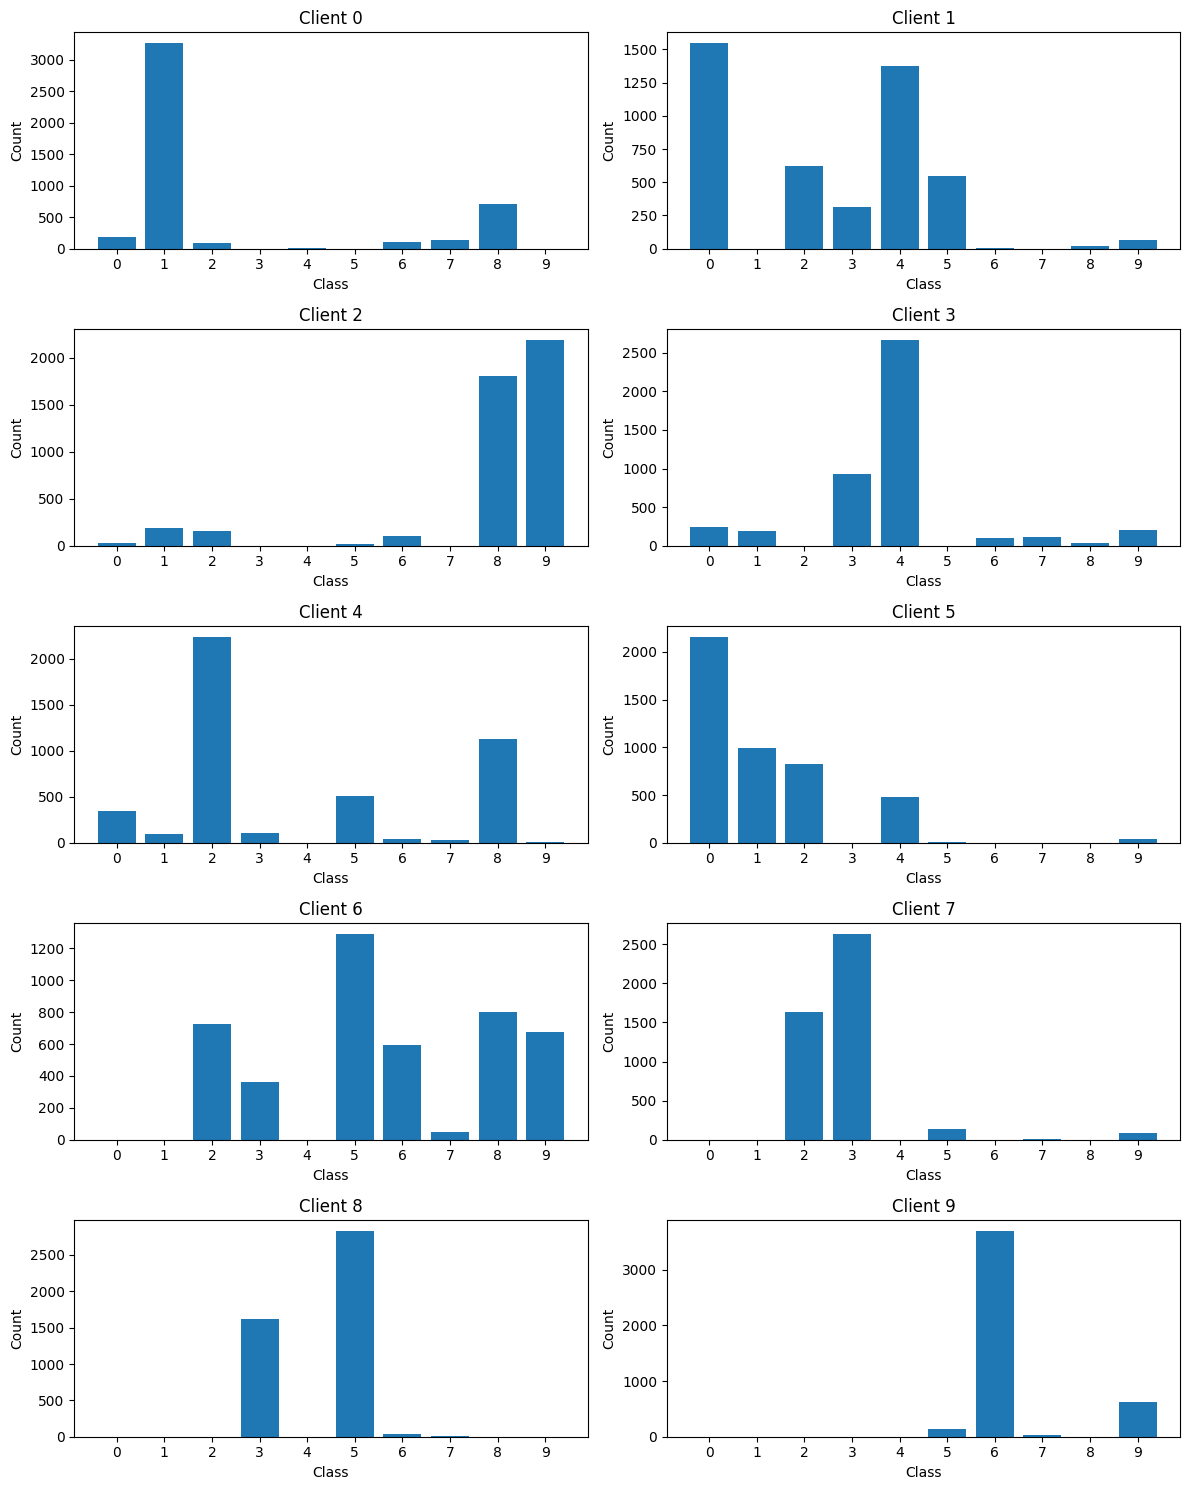


----------------------------------------------------------------------
                         DATASET DISTRIBUTION                         
----------------------------------------------------------------------
Total Training Data: 45,000
Test Data: 10,000
Unseen Data Pool: 5,000

Federated Learning Setup:
   Forget Set Size: 4,500
   Retain Set Size: 40,500
   IID Unseen Data for Generation: 4,500
----------------------------------------------------------------------

----------------------------------------------------------------------
                 PHASE 1: Original FEDERATED LEARNING                 
----------------------------------------------------------------------


Original FL Training:  25%|██▌       | 5/20 [22:00<1:06:10, 264.68s/it]

[Standard FL] Epoch 5/20 | Loss: 0.0780 | Acc: 42.26%


Original FL Training:  50%|█████     | 10/20 [44:04<44:04, 264.49s/it] 

[Standard FL] Epoch 10/20 | Loss: 0.0448 | Acc: 65.30%

[UNLEARNING REQUEST] Client 0 requests unlearning at epoch 11

----------------------------------------------------------------------
            PHASE 2: SOURCE-FREE SYNTHETIC DATA GENERATION            
----------------------------------------------------------------------
[Source-Free] Server provides IID unseen data to unlearning client...
[Source-Free] Client generates synthetic data without direct forget data access...
[DCGAN] Using Forget: 4500 + Unseen: 4500 samples with REVERSED distribution mixing
[DCGAN] Starting REVERSED distribution mixing training for 200 epochs
[Target] Generate images that LOOK LIKE unseen but FOLLOW forget distribution


[0/200][0/70] Loss_D: 1.5068 Loss_G: 2.3612 (Adv: 2.3094, Dist: 0.0446, Style: 0.0590) D(x): 0.5115 D(G(z)): 0.5110 / 0.1138
[DCGAN] Saving REVERSED distribution-mixed sample images...
[0/200][25/70] Loss_D: 1.1528 Loss_G: 5.4822 (Adv: 5.4424, Dist: 0.0280, Style: 0.0516) D(x): 0.6297 D(G(z)): 0.3974 / 0.0058
[0/200][50/70] Loss_D: 0.3819 Loss_G: 4.9009 (Adv: 4.8691, Dist: 0.0193, Style: 0.0443) D(x): 0.7890 D(G(z)): 0.1032 / 0.0098
[DCGAN] Saving REVERSED distribution-mixed sample images...
[1/200][0/70] Loss_D: 0.2317 Loss_G: 5.1816 (Adv: 5.1404, Dist: 0.0306, Style: 0.0517) D(x): 0.8972 D(G(z)): 0.1026 / 0.0071
[DCGAN] Saving REVERSED distribution-mixed sample images...
[1/200][25/70] Loss_D: 0.6920 Loss_G: 3.3007 (Adv: 3.2545, Dist: 0.0259, Style: 0.0665) D(x): 0.7236 D(G(z)): 0.2519 / 0.0468
[1/200][50/70] Loss_D: 0.6597 Loss_G: 3.4773 (Adv: 3.4343, Dist: 0.0154, Style: 0.0706) D(x): 0.8110 D(G(z)): 0.3125 / 0.0455
[DCGAN] Saving REVERSED distribution-mixed sample images...
[2/200

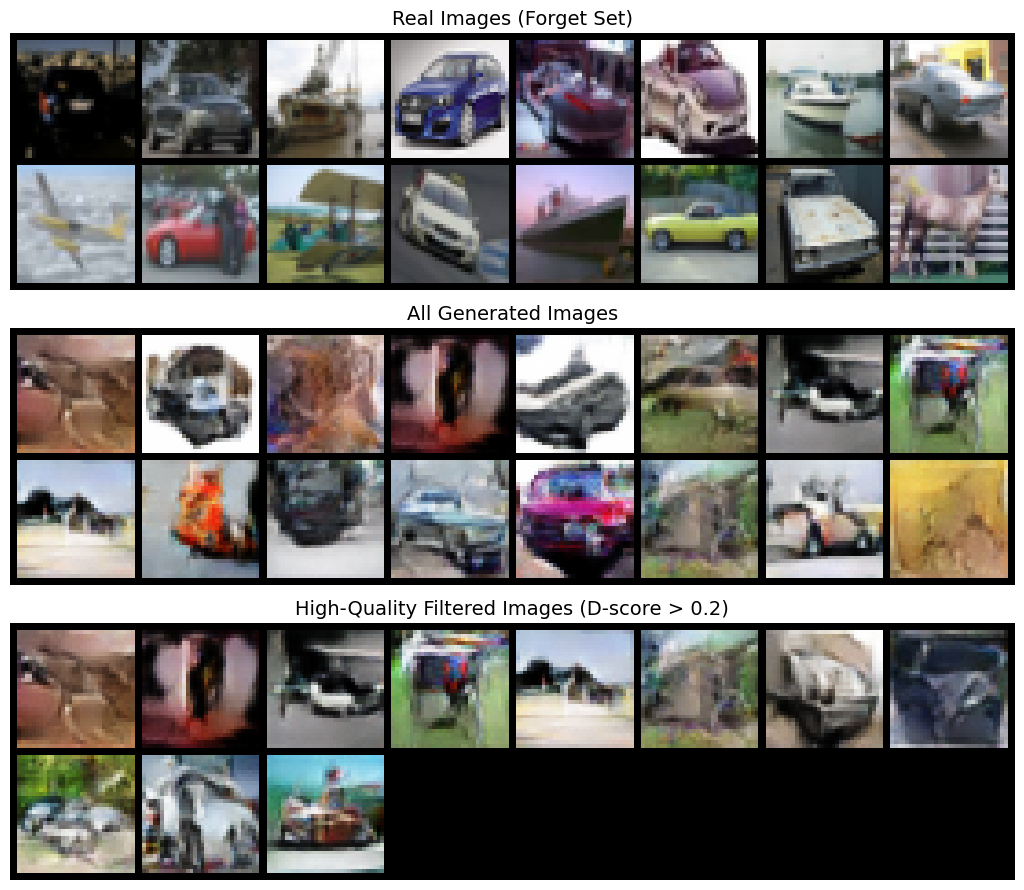

Discriminator Scores - Mean: 0.153, Std: 0.120
Comparison image saved to: ./real_vs_generated_filtered.png

----------------------------------------------------------------------
           BASELINE : ORIGINAL MODEL (IGNORING UNLEARNING)            
----------------------------------------------------------------------


Original Continue Training: 100%|██████████| 10/10 [40:13<00:00, 241.38s/it]



----------------------------------------------------------------------
             BASELINE : RETRAIN MODEL (IDEAL UNLEARNING)              
----------------------------------------------------------------------


Retrain FL Training: 100%|██████████| 20/20 [1:07:19<00:00, 201.98s/it]



----------------------------------------------------------------------
                  Baseline : SIMPLE Finetune PROCESS                  
----------------------------------------------------------------------


Finetune FL:  50%|█████     | 5/10 [16:42<16:43, 200.63s/it]

[Post-Unlearning FL] Epoch 5/10 | Loss: 0.0157


Finetune FL: 100%|██████████| 10/10 [33:22<00:00, 200.29s/it]


[Post-Unlearning FL] Epoch 10/10 | Loss: 0.0129

----------------------------------------------------------------------
             BaseLine : UNLEARN MODEL WITH SYNTHETIC DATA             
----------------------------------------------------------------------


Unlearning FL:   0%|          | 0/10 [00:00<?, ?it/s]

[Synthetic Update] Training with 4500 synthetic samples
[Synthetic Update] Completed with average loss: 0.0164


Unlearning FL:  10%|█         | 1/10 [03:33<32:04, 213.81s/it]

[Synthetic Update] Training with 4500 synthetic samples
[Synthetic Update] Completed with average loss: 0.0061


Unlearning FL:  20%|██        | 2/10 [07:06<28:24, 213.12s/it]

[Synthetic Update] Training with 4500 synthetic samples
[Synthetic Update] Completed with average loss: 0.0112


Unlearning FL:  30%|███       | 3/10 [10:39<24:52, 213.27s/it]

[Synthetic Update] Training with 4500 synthetic samples


Unlearning FL:  40%|████      | 4/10 [14:12<21:18, 213.01s/it]

[Synthetic Update] Completed with average loss: 0.0044
[Synthetic Update] Training with 4500 synthetic samples
[Synthetic Update] Completed with average loss: 0.0195


Unlearning FL:  50%|█████     | 5/10 [17:45<17:45, 213.08s/it]

[Unlearning FL] Epoch 5/10 | Loss: 0.0262
[Synthetic Update] Training with 4500 synthetic samples
[Synthetic Update] Completed with average loss: 0.0037


Unlearning FL:  60%|██████    | 6/10 [21:20<14:14, 213.54s/it]

[Synthetic Update] Training with 4500 synthetic samples
[Synthetic Update] Completed with average loss: 0.0247


Unlearning FL:  70%|███████   | 7/10 [24:52<10:39, 213.25s/it]

[Synthetic Update] Training with 4500 synthetic samples
[Synthetic Update] Completed with average loss: 0.0034


Unlearning FL:  80%|████████  | 8/10 [28:24<07:05, 212.83s/it]

[Synthetic Update] Training with 4500 synthetic samples
[Synthetic Update] Completed with average loss: 0.0247


Unlearning FL:  90%|█████████ | 9/10 [31:56<03:32, 212.51s/it]

[Synthetic Update] Training with 4500 synthetic samples
[Synthetic Update] Completed with average loss: 0.0032


Unlearning FL: 100%|██████████| 10/10 [35:30<00:00, 213.05s/it]

[Unlearning FL] Epoch 10/10 | Loss: 0.0145

----------------------------------------------------------------------
                       COMPREHENSIVE EVALUATION                       
----------------------------------------------------------------------

========== Comprehensive Model Comparison ==========

--- Evaluating Original Model ---


[Classification] Original Test Accuracy: 67.63% (6763/10000)
[Classification] Original Retain Accuracy: 87.25% (35338/40500)
[Classification] Original Forget Accuracy: 89.89% (4045/4500)
[Classification] Original Synthetic Accuracy: 12.27% (552/4500)
[Summary] Original - Test: 0.676, Retain: 0.873, Forget: 0.899, MIA: 0.554, Time: 17.27s

--- Evaluating Retrain Model ---
[Classification] Retrain Test Accuracy: 64.41% (6441/10000)
[Classification] Retrain Retain Accuracy: 85.56% (34653/40500)
[Classification] Retrain Forget Accuracy: 63.78% (2870/4500)
[Classification] Retrain Synthetic Accuracy: 12.53% (564/4500)
[Summary] Retrain - Test: 0.644, Retain: 0.856, Forget: 0.638, MIA: 0.602, Time: 17.79s

--- Evaluating Finetune Model ---
[Classification] Finetune Test Accuracy: 64.33% (6433/10000)
[Classification] Finetune Retain Accuracy: 85.35% (34568/40500)
[Classification] Finetune Forget Accuracy: 66.64% (2999/4500)
[Classification] Finetune Synthetic Accuracy: 13.98% (629/4500)
[Summ

{'original_acc': 0.6763,
 'retrain_acc': 0.6441,
 'finetune_acc': 0.6433,
 'unlearn_acc': 0.5722,
 'original_time': 2413.8158490657806,
 'retrain_time': 4039.819003343582,
 'finetune_time': 2002.9542298316956,
 'unlearn_time': 2130.532421350479,
 'generation_time': 617.8317785263062,
 'synthetic_count': 4500,
 'mia_scores': {'original': 0.651410024691358,
  'retrain': 0.4744607654320988,
  'finetune': 0.45264740740740744,
  'unlearn': 0.48923525925925926}}

In [5]:
main()